# Import Libraries 

In [1]:
# Essential Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Model Selection and Evaluation
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import PolynomialFeatures

# Model Selection and Evaluation
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import optuna

# Model
from lightgbm import LGBMRegressor


# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test  = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

# add the 'dataset' column to distinguish train and test data
train['dataset'] = 'train'
test['dataset'] = 'test'

# train['num_sold'].fillna(method='ffill', inplace=True)

# concatenate the datasets with the added 'dataset' column
df = pd.concat([train, test], axis=0).reset_index(drop=True)

# Exploratory Data Analysis (EDA)

In [3]:
df

,id,date,country,store,product,num_sold,dataset
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,train
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,train
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,train
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,train
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,train
...,...,...,...,...,...,...,...
328675,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,NaN,test
328676,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,NaN,test
328677,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,NaN,test
328678,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler,NaN,test


In [4]:
# Checking the shape of the combined dataset (number of rows and columns)

df.shape

(328680, 7)

In [5]:
# Displaying data types and non-null counts for each column to understand data structure

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328680 entries, 0 to 328679
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        328680 non-null  int64  
 1   date      328680 non-null  object 
 2   country   328680 non-null  object 
 3   store     328680 non-null  object 
 4   product   328680 non-null  object 
 5   num_sold  221259 non-null  float64
 6   dataset   328680 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 17.6+ MB


## Check for Missing Values

In [6]:
# Checking for missing values in the dataset

df.isnull().sum()

id               0
date             0
country          0
store            0
product          0
num_sold    107421
dataset          0
dtype: int64

## Convert Data Types

In [7]:
# Convert the date column from object to datetime for time-series analysis.

df['date'] = pd.to_datetime(df['date'])

### Extract Useful Date Features

In [8]:
# Extracting time-based features (month, day of the week, quarter, etc.)
# Applying cyclic transformations to handle periodicity in features

df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek
# df['dayofyear'] = df['date'].dt.dayofyear
df['quarter'] = df['date'].dt.quarter
df['weekofyear'] = df['date'].dt.isocalendar().week #Week of the year
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day

# Apply sine and cosine transformations to cyclical features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  # Assuming 31 days max
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df['day_of_week_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df['week_of_year_sin'] = np.sin(2 * np.pi * df['weekofyear'] / 52)
df['week_of_year_cos'] = np.cos(2 * np.pi * df['weekofyear'] / 52)

df['Group'] = (df['year'] - 2010) * 48 + df['month'] * 4 + df['day'] // 7

## Summary Statistics

### Descriptive Statistics for num_sold

In [9]:
# Generating summary statistics for the 'num_sold' column

df['num_sold'].describe()

count    221259.000000
mean        752.527382
std         690.165445
min           5.000000
25%         219.000000
50%         605.000000
75%        1114.000000
max        5939.000000
Name: num_sold, dtype: float64

### Unique Values for Categorical Columns

In [10]:
# Checking unique values for categorical columns like 'country', 'store', and 'product'

print(df['country'].unique())
print(df['store'].unique())
print(df['product'].unique())

['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


## Visualizations

### num_sold by date to observe trends and seasonality.

<Axes: title={'center': 'Total Sales Over Time'}, xlabel='date'>

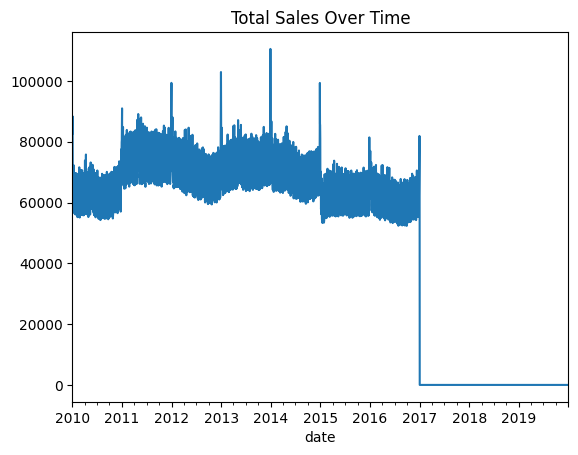

In [11]:
# Plotting total sales by date to observe trends and seasonality

sales_by_date = df.groupby('date')['num_sold'].sum()
sales_by_date.plot(title='Total Sales Over Time')

### visualize sales by country, store, and product to identify high-performing categories.

<Axes: title={'center': 'Sales by Country'}, xlabel='country'>

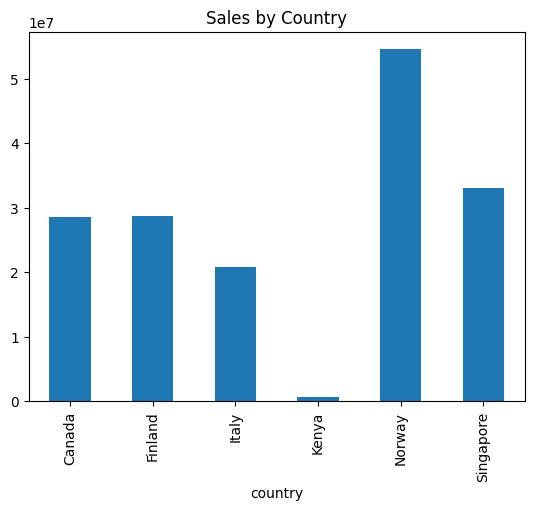

In [12]:
# Creating bar plots for sales by country, store, and product to identify high-performing categories

sales_by_country = df.groupby('country')['num_sold'].sum()
sales_by_country.plot(kind='bar', title='Sales by Country')

<Axes: title={'center': 'Sales by store'}, xlabel='store'>

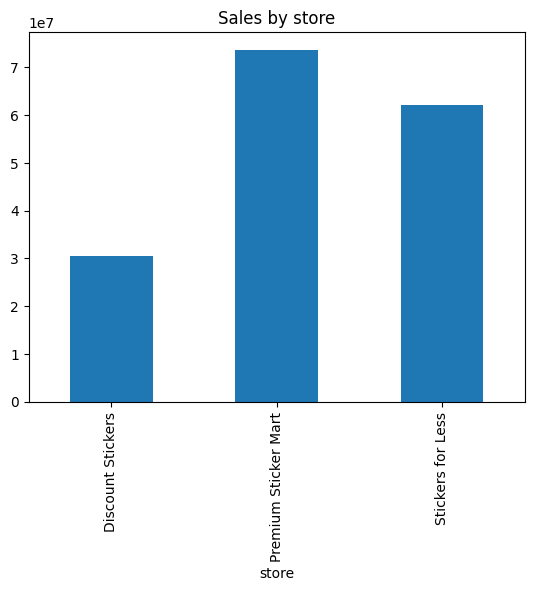

In [13]:
sales_by_store = df.groupby('store')['num_sold'].sum()
sales_by_store.plot(kind='bar', title='Sales by store')

<Axes: title={'center': 'Sales by product'}, xlabel='product'>

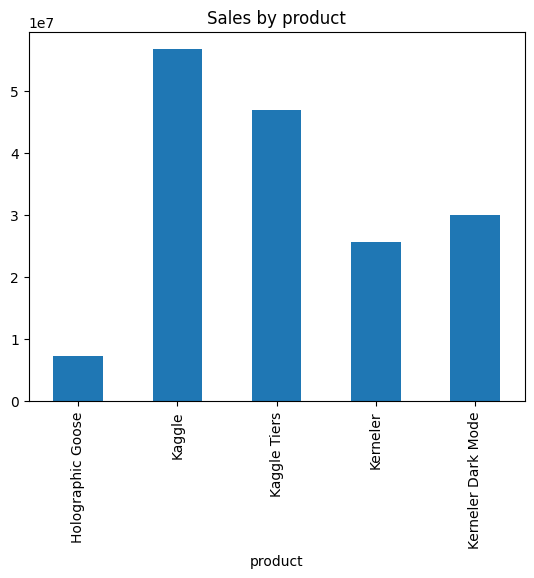

In [14]:
sales_by_product = df.groupby('product')['num_sold'].sum()
sales_by_product.plot(kind='bar', title='Sales by product')

### Outlier Detection

Use box plots to identify outliers visually.
Outliers are typically data points outside the whiskers (1.5 times the interquartile range, IQR).

In [15]:
# Calculate Outlier Bounds Using IQR
# Calculating Interquartile Range (IQR) to identify potential outliers
# Filtering rows where 'num_sold' is outside the lower and upper bounds

# Recalculate Q1, Q3, and IQR
Q1 = df['num_sold'].quantile(0.25)
Q3 = df['num_sold'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['num_sold'] < lower_bound) | (df['num_sold'] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

Number of Outliers: 6630


<Figure size 1000x600 with 0 Axes>

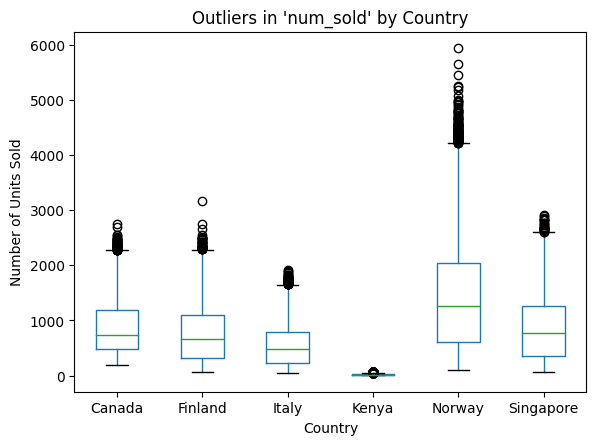

In [16]:
# Visualizing outliers using box plots grouped by different categorical features

plt.figure(figsize=(10, 6))
df.boxplot(column='num_sold', by='country', grid=False)
plt.title("Outliers in 'num_sold' by Country")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel('Number of Units Sold')
plt.xlabel('Country')
plt.show()

<Figure size 1200x600 with 0 Axes>

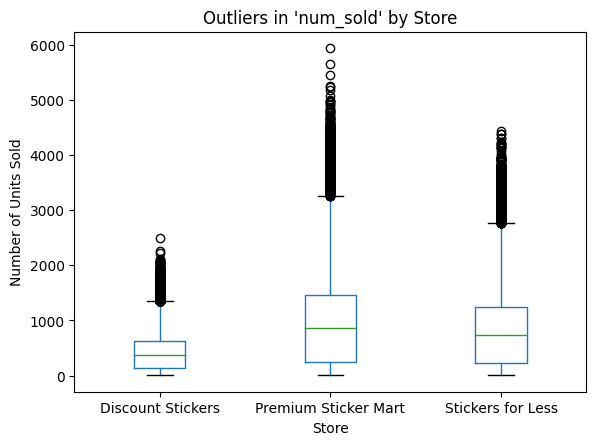

In [17]:
plt.figure(figsize=(12, 6))
df.boxplot(column='num_sold', by='store', grid=False)
plt.title("Outliers in 'num_sold' by Store")
plt.suptitle("")
plt.ylabel('Number of Units Sold')
plt.xlabel('Store')
plt.show()

<Figure size 1200x600 with 0 Axes>

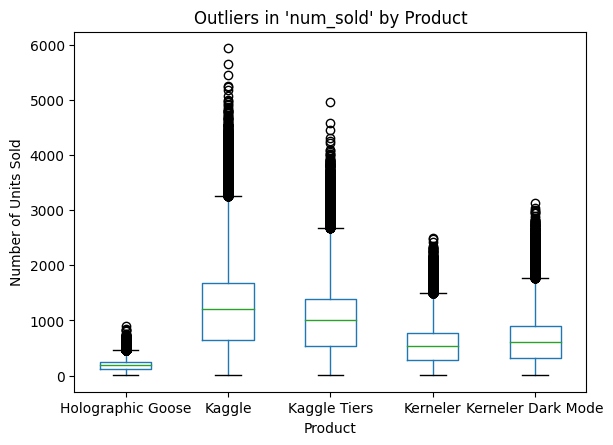

In [18]:
plt.figure(figsize=(12, 6))
df.boxplot(column='num_sold', by='product', grid=False)
plt.title("Outliers in 'num_sold' by Product")
plt.suptitle("")
plt.ylabel('Number of Units Sold')
plt.xlabel('Product')
plt.show()

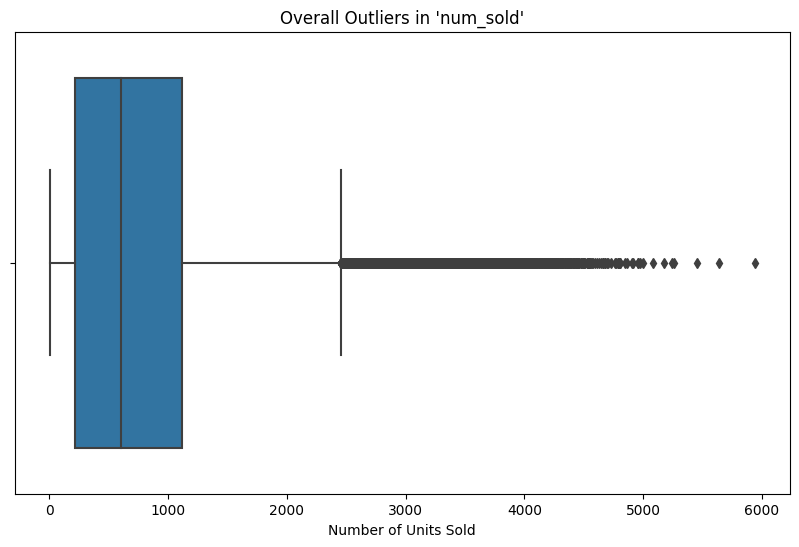

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['num_sold'])
plt.title("Overall Outliers in 'num_sold'")
plt.xlabel('Number of Units Sold')
plt.show()

Majority of Data:

The majority of the data points lie within the box (spanning the interquartile range, IQR) and the whiskers.
Most num_sold values are concentrated below approximately 1000 units.
Outliers:

There are a significant number of outliers beyond the upper whisker, with extreme values reaching up to 6000 units sold.
These outliers could represent genuine high sales events (e.g., holiday sales) or data anomalies.

In [20]:
# Group outliers by country
outliers_by_country = outliers.groupby('country').size()
print("Outliers by Country:")
print(outliers_by_country)

# Group outliers by store
outliers_by_store = outliers.groupby('store').size()
print("Outliers by Store:")
print(outliers_by_store)

# Group outliers by product
outliers_by_product = outliers.groupby('product').size()
print("Outliers by Product:")
print(outliers_by_product)

Outliers by Country:
country
Canada         11
Finland        11
Norway       6521
Singapore      87
dtype: int64
Outliers by Store:
store
Discount Stickers          1
Premium Sticker Mart    4175
Stickers for Less       2454
dtype: int64
Outliers by Product:
product
Kaggle                4169
Kaggle Tiers          2347
Kerneler                 2
Kerneler Dark Mode     112
dtype: int64


In [21]:
outliers_by_month = outliers.groupby('month').size()
print("Outliers by Month:")
print(outliers_by_month)

Outliers by Month:
month
1     597
2     495
3     563
4     594
5     639
6     532
7     526
8     521
9     501
10    534
11    511
12    617
dtype: int64


In [22]:
outliers_by_day = outliers.groupby('dayofweek').size()
print("Outliers by Day of the Week:")
print(outliers_by_day)

Outliers by Day of the Week:
dayofweek
0     787
1     779
2     789
3     799
4     947
5    1109
6    1420
dtype: int64


In [23]:
outliers_by_year = outliers.groupby('year').size()
print("Outliers by Year:")
print(outliers_by_year)

Outliers by Year:
year
2010     752
2011    1332
2012    1273
2013    1340
2014    1132
2015     518
2016     283
dtype: int64


# Data Preprocessing

## Handle Missing Values

In [24]:
# replace with zero 
# Drop rows where 'dataset' is 'train' and 'num_sold' is NaN
df = df[~((df['dataset'] == 'train') & (df['num_sold'].isna()))]


# df.loc[df['dataset'] == 'train', 'num_sold'] = df.loc[df['dataset'] == 'train', 'num_sold'].fillna(0)

## Handle Outliers

In [25]:
# Apply a logarithmic transformation to 'num_sold' to reduce skewness and stabilize variance.
# This transformation helps to handle outliers by compressing large values, making the data 
# more suitable for statistical analysis and modeling.
df['num_sold'] = np.log(df['num_sold'])

# # Apply a logarithmic transformation to 'num_sold' to reduce skewness and stabilize variance.
# # Add a small constant (+1) to handle potential zero values, ensuring the transformation is valid.
# df['log_num_sold'] = np.log(df['num_sold'] + 1)

## Feature Engineering

### Encoding 

In [26]:
# Function for Target Encoding multiple categorical columns
def target_encoding_multiple_columns(df, target_column, categorical_columns, dataset_column='dataset'):
    for col in categorical_columns:
        # Calculate target mean for each category in the column using training data
        target_mean = df[df[dataset_column] == 'train'].groupby(col)[target_column].mean()

        # Map the target mean encoding to the entire dataset
        df[f'{col}_encoded'] = df[col].map(target_mean)

        # Handle missing values for categories not present in training
        df[f'{col}_encoded'].fillna(df[target_column].mean(), inplace=True)

    return df
# Example usage: Apply Target Encoding to multiple columns
categorical_columns = ['country', 'store', 'product']
df = target_encoding_multiple_columns(df, target_column='num_sold', categorical_columns=categorical_columns)

In [27]:
# Encoding categorical variables (country, store, product) as dummy variables
# Avoiding the dummy variable trap by dropping the first category in each column

df = pd.get_dummies(df, columns=['country', 'store', 'product'], dtype=int, drop_first=True)

In [28]:
df.head()

,id,date,num_sold,dataset,month,dayofweek,quarter,weekofyear,year,day,...,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Premium Sticker Mart,store_Stickers for Less,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
1,1,2010-01-01,6.880384,train,1,4,1,53,2010,1,...,0,0,0,0,0,0,1,0,0,0
2,2,2010-01-01,6.809039,train,1,4,1,53,2010,1,...,0,0,0,0,0,0,0,1,0,0
3,3,2010-01-01,6.047372,train,1,4,1,53,2010,1,...,0,0,0,0,0,0,0,0,1,0
4,4,2010-01-01,6.196444,train,1,4,1,53,2010,1,...,0,0,0,0,0,0,0,0,0,1
5,5,2010-01-01,5.703782,train,1,4,1,53,2010,1,...,0,0,0,0,0,1,0,0,0,0


# Modeling

## Train-Test Split

For time-series data, splitting must preserve the temporal order of data to avoid data leakage. The training set consists of earlier data points, while the test set includes later data points.

In [29]:
# Splitting the training dataset into train and validation sets
# Ensuring the split preserves the time series order

# Separate train and test datasets
train_df = df[df['dataset'] == 'train'].drop(columns=['dataset'], errors='ignore')
test_df = df[df['dataset'] == 'test'].drop(columns=['dataset'], errors='ignore')


# Drop unnecessary columns from both datasets
train_df = train_df.drop(columns=['id'], errors='ignore')
test_df = test_df.drop(columns=['num_sold'], errors='ignore')

# Sort training data by date to preserve time series order
train_df = train_df.sort_values(by='date')


# Separate features and target
X = train_df.drop(['num_sold'], axis=1)
y = train_df['num_sold']


# Drop the 'date' column after feature extraction
X = X.drop(columns=['date'], errors='ignore')
y = y.drop(columns=['date'], errors='ignore')

In [30]:
X.columns

Index(['month', 'dayofweek', 'quarter', 'weekofyear', 'year', 'day',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'week_of_year_sin', 'week_of_year_cos', 'Group',
       'country_encoded', 'store_encoded', 'product_encoded',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode'],
      dtype='object')

## Modeling with LightGBM

LightGBM in combination with Optuna for hyperparameter optimization.

In [31]:
# # Define the objective function for Optuna, which evaluates LightGBM's performance
# def objective(trial):
#     # Suggest hyperparameter values to be optimized by Optuna
#     params = {
#         "num_leaves": trial.suggest_int("num_leaves", 16, 128),  # Maximum leaves in one tree
#         "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),  # Learning rate for gradient boosting
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),  # Number of boosting rounds
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),  # Fraction of samples used per iteration
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # Fraction of features used for each tree
#         "random_state": 42,  # Ensures reproducibility
#     }
    
    
#     # # Use TimeSeriesSplit to preserve temporal order during cross-validation
#     # tscv = TimeSeriesSplit(n_splits=3)

#         # Group column (e.g., 'group')
#     group_col = X['Group']
    
#     # Define the GroupKFold cross-validation
#     gkf = GroupKFold(n_splits=10)
#     model = LGBMRegressor(**params)  # Initialize the LightGBM model with current parameters
    
#     errors = []  # List to store validation errors for each fold
#     for train_index, val_index in gkf.split(X, X['Group'], groups=group_col):  # Split training data for cross-validation
#         X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]  # Train/validation splits
#         y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
        

        
#         model.fit(X_train_cv, y_train_cv)  # Train the model on the current fold
#         y_val_pred = model.predict(X_val_cv)  # Predict on the validation set
#         errors.append(mean_squared_error(y_val_cv, y_val_pred))  # Calculate and store MSE
    
#     # Calculate the Root Mean Squared Error (RMSE) for the current trial
#     rmse = np.sqrt(np.mean(errors))
#     return rmse  # Return RMSE as the objective value for Optuna to minimize

# # Initialize an Optuna study for hyperparameter optimization
# study = optuna.create_study(direction="minimize")  # Minimize RMSE
# study.optimize(objective, n_trials=30)  # Optimize the objective function over 30 trials

# # Print the best hyperparameters found during optimization
# print("Best trial:", study.best_trial.params)

## This is output of optuna : 
{
    'num_leaves': 127, 
    'learning_rate': 0.0989627523617693, 
    'n_estimators': 400, 
    'subsample': 0.8615034945856372, 
    'colsample_bytree': 0.8050238118519274
} 

In [32]:
# Separate features (X) and target variable (y) from the training data
# Dropping 'num_sold' as it's the target variable
# Dropping 'date' to avoid any unintended leakage since it is not used as a feature
X = train_df.drop(columns=['num_sold', 'date']).copy()
y = train_df['num_sold'].copy()

# # Retrieve the best hyperparameters from the Optuna study
# best_params = study.best_params
# print("Best hyperparameters:", best_params)

# Predefined best hyperparameters
best_params = {
    'num_leaves': 127, 
    'learning_rate': 0.0989627523617693, 
    'n_estimators': 400, 
    'subsample': 0.8615034945856372, 
    'colsample_bytree': 0.8050238118519274
}


# Instantiate the LightGBM model with the optimal hyperparameters
best_model = LGBMRegressor(**best_params)

# Train the model using all available training data (X, y)
best_model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 221259, number of used features: 29
[LightGBM] [Info] Start training from score 5.925537


LGBMRegressor(colsample_bytree=0.8050238118519274,
              learning_rate=0.0989627523617693, n_estimators=400,
              num_leaves=127, subsample=0.8615034945856372)

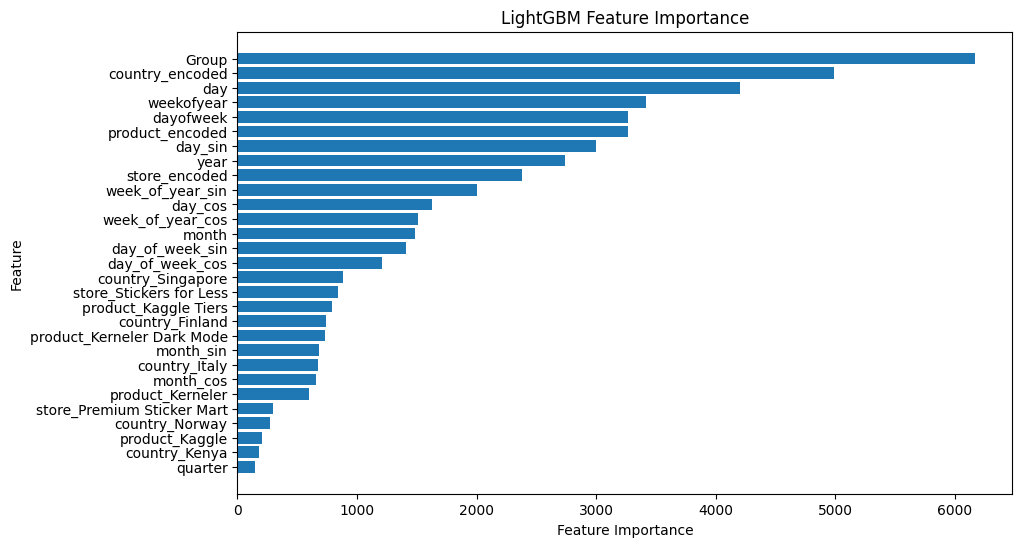

In [33]:
# Feature importance values
# importance = model.feature_importances_
importance = best_model.feature_importances_

# Feature names
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Submition

In [34]:
# Preprocess test data
test_features = test_df.drop(columns=['id', 'date'], errors='ignore')  # Drop unnecessary columns
# test_features = test_features.reindex(columns=X.columns, fill_value=0)  # Align columns with training data

In [35]:
test_df['num_sold'] = best_model.predict(test_features)

In [36]:
# Reverse log transformation if applied during training
test_df['num_sold'] = np.expm1(test_df['num_sold'])  # Use np.expm1 if np.log1p was used during training

# Clip predictions to avoid negative values (optional)
test_df['num_sold'] = test_df['num_sold'].clip(lower=1)

In [37]:
# Create submission file
submission = test_df[['id', 'num_sold']]  # Include 'id' and the predicted target column
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

Submission file created: submission.csv


In [38]:
submission

,id,num_sold
230130,230130,157.652549
230131,230131,928.924789
230132,230132,723.461621
230133,230133,387.270551
230134,230134,490.652890
...,...,...
328675,328675,373.248537
328676,328676,2338.248412
328677,328677,1828.987460
328678,328678,1087.056042


# Score : 0.08516 
# Update, Add TargetEncoder Score : 0.08444 
(TargetEncoder and dummy variables both)
# Update, Add TargetEncoder Score : 0.08237
(I change TimeSeriesSplit to GroupKFold)
# It will be updated 